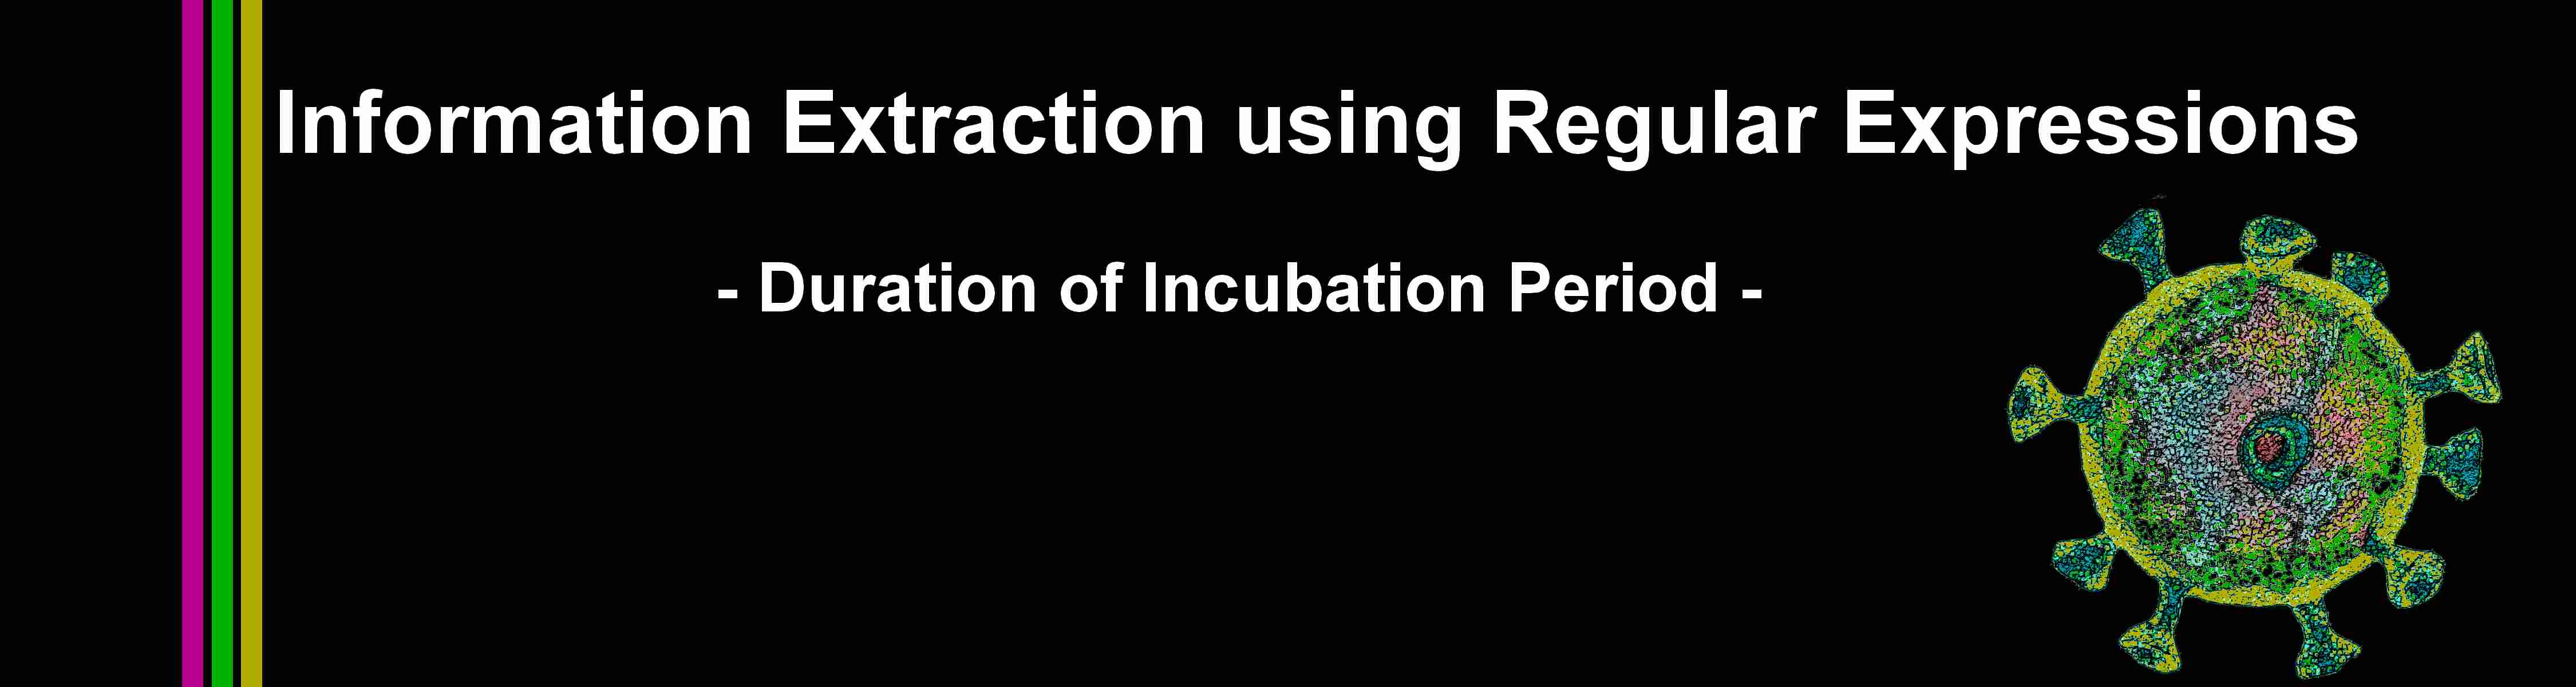

As the number of articles on COVID-19 is already huge, this notebook applies an automatized information extraction based on regular expressions. Since this is my first kaggle participation, any feedback is very welcomed. Thank you!

# 1. Import packages

In [ ]:
import os
import json
import pandas as pd
import re
from nltk import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("bmh")

# 2. Read-in the meta-information and all articles

I import the metadata-file and also go though each json-file in each folder and extract all relevant information for our analysis. In specific, following variables for each article are stored:
* paper_id: Identification code
* title: Title
* authors: Authors
* abstract: article abstract
* body_text: Full article text
* publish_time: Date of publication
* journal: Journal of publication
* source_folder: the name of the folder, where the article is stored in


In [ ]:
# Read meta information
df_meta = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv", index_col="sha")    

# Read and format articles from each folder
dirs = ["biorxiv_medrxiv", "comm_use_subset", "custom_license", "noncomm_use_subset"]

# Initialize an empty list
docs = []

# Loop over json-files and extract information to docs
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dirname[-4:] == "json":
            # Load file
            j = json.load(open((os.path.join(dirname, filename)), "rb"))

            # Extract the information    
            paper_id = j["paper_id"]

            title = j["metadata"]["title"]

            authors = j["metadata"]["authors"]

            try:
                abstract = j["abstract"][0]
            except:
                abstract = ""

            full_text = ""    
            for text in j["body_text"]:
                full_text += text["text"] + " "

            # Get meta data information for the file
            file_code = filename.split(".")[0]

            try:
                publish_time = df_meta.loc[file_code, "publish_time"]
            except KeyError:
                publish_time = ""

            try:
                journal = df_meta.loc[file_code, "journal"]
            except KeyError:
                journal= ""    

            try:
                source_folder = df_meta.loc[file_code, "full_text_file"]
            except KeyError:
                source_folder = ""

            # Append all information to docs
            docs.append([paper_id, title, abstract, full_text, 
                         publish_time, journal, authors, source_folder])

Having retrieved all this information, our main DataFrame for analysis, called *df*, is generated. Shape and head of *df* look like like that:

In [ ]:
# Build up DataFrame
df = pd.DataFrame(docs, columns=["paper_id", "title", "abstract", "full_text",
                                 "publish_time", "journal", "authors", "source_folder"])
print(df.head())
print("\n# of rows and columns:", df.shape)


# 3. Now we extract the information on incubation of COVID-19
The following code will go over each sentence in all articles and check for numbers on the duration of COVID-19 incubation period. The information is extracted using regular expressions and is stored in new columns of the main datafaIn order to extract the right information, the following steps are applied in order:

**Tokenization and Lowercasing:**
The nltk sentence tokenization is exploited to split the article bodies into sentences. Also all steps are applied on the lower-cased sentences.

**Filtering:**
Clearly, there are many synonyms used for incubation and COVID-19 - hence they will be checked for, too. Also, I want to make sure to only extract COVID-19-related incubation references and miss incubation references relating to other illnesses. Hence, a sentence of interest contains a COVID-19 reference as well as a incubation reference as well as a duration expression (e.g. day, d or hour).

**Measures:**
Statements on incubation can refer to different measures like the mean, median, 1st quartile or 3rd quartile. The filtered sentence is scanned for each of these measures (includes synonyms like mean(s) and average(s)). 

**Number Extraction:**
I extract the number from a number-date-expression (e.g. "4.0 days" or "72 to 88 hours") that follows (!) the measure. Notably, the regular espression used captures
* floats, e.g. "4.2" 
* integers, e.g. "5"
* ranges, e.g. "3-4" or "3 - 4" or "3 to 4" or (between) "3 and for" (Notably, "-" unicode characters 8722 and 45 are both included)
* combinations of these, e.g. "3 to 3.8"


In [ ]:
# Generate filters
covid19_synonyms = ['covid',
                    'coronavirus disease 19',
                    'sars cov 2', 
                    '2019 ncov',
                    '2019ncov',
                    '2019 n cov',
                    '2019n cov',
                    'ncov 2019',
                    'n cov 2019',
                    'coronavirus 2019',
                    'wuhan pneumonia',
                    'wuhan virus',
                    'wuhan coronavirus',
                    'coronavirus',
                    'coronavirus-disease',
                    'coronavirus disease',
                    'coronavirus-disease 19',
                    'sars-cov-2', 
                    '2019-ncov',
                    '2019 n-cov',
                    '2019-n-cov',
                    '2019n-cov',
                    'ncov-2019',
                    'n-cov 2019',
                    'n-cov-2019',
                    'coronavirus-2019',
                    'wuhan-pneumonia',
                    'wuhan-virus',
                    'wuhan-coronavirus',
                    'corona-virus']


incubation_synonyms = ['incubation period',
                       'period of incubation',
                       'latent period',
                       'latency period',
                       'period of latency',
                       'window period',
                       'incubation',
                       'incubate']

duration_expression = ['\sday|', '\sd|' '\shour|', '\shr']
number_expression = r"(\d+(?:\.\d+)?(?:\-\d+(?:\.\d+)?)?(?:\−\d+(?:\.\d+)?)?(?:\s\-\s\d+(?:\.\d+)?)?(?:\s\−\s\d+(?:\.\d+)?)?(?:\sto\s\d+(?:\.\d+)?)?(?:\sand\s\d+(?:\.\d+)?)?)"

number_date_expression = number_expression + number_expression.join([d for d in duration_expression])
print("Regex Number-Date-Expressions:\n", number_date_expression)


In [ ]:
# Extract incubation information
for id, text in enumerate(df["full_text"]):
    article_incubation_sentences = str()
    article_incubation_means = str()
    article_incubation_medians = str()
    article_incubation_max = str()
    article_incubation_min = str()
    article_incubation_iqr = str()
    #for sentence in text.split(". "):
    for sentence in sent_tokenize(text, language="english"):
        # Replace false float representations (e.g. "4·5" instead of 4.5)
        sentence = sentence.replace("·", ".")
        # For each sentence, look for covid19 synonym ...
        if len(re.findall("|".join(covid19_synonyms), sentence.lower())) > 0:
            # ... as well as an incubation synonym ...
            if len(re.findall("|".join(incubation_synonyms), sentence.lower())) > 0:
                # ... as well as a duration expression.
                if len(re.findall("|".join(duration_expression), sentence.lower())) > 0:
                    # We append these sentences for each article ...
                    article_incubation_sentences += sentence + "\n\n"
                    # ... and store the incubation sentences to our dataframe df
                    df.loc[id, "incubation_sentences"] = article_incubation_sentences
                    # Extract mean information
                    # See whether mean is present in sentence
                    if len(re.findall("\smean\s|average", sentence.lower())) > 0:
                        if re.findall("\smean\s|average", sentence.lower())[0] == " mean ":
                            mean_syn = "mean"
                        elif re.findall("\smean\s|average", sentence.lower())[0] == "average":
                            mean_syn = "average"
                        # Reduce sentence to part after "mean" is mentioned
                        sentence_reduced = sentence.lower().split(mean_syn, maxsplit=1)[1]
                        # Now extract the first (!) number-duration expression, which likely refers to the mean
                        try: 
                            mean_expression = re.search(number_date_expression, sentence_reduced)[0]
                            # For each article store the expressions from each sentence
                            article_incubation_means += mean_expression + "; "
                        except TypeError:
                            pass
                        # Store the measures in our dataframe df, reject empty strings
                        if len(article_incubation_means) > 0:
                            df.loc[id, "incubation_mean"] = article_incubation_means
                    # See whether median is present in sentence
                    if len(re.findall("median", sentence.lower())) > 0:
                        # Reduce sentence to part after "median" is mentioned
                        sentence_reduced = sentence.lower().split("median", maxsplit=1)[1]
                        # Now extract the first (!) number-duration expression, which likely refers to the median
                        try:
                            median_expression = re.search(number_date_expression, sentence_reduced)[0]
                            # For each article store the expressions from each sentence
                            article_incubation_medians += median_expression + "; "
                        except TypeError:
                            pass
                        # Store the measures in our dataframe df, reject empty strings
                        if len(article_incubation_medians) > 0:
                            df.loc[id, "incubation_median"] = article_incubation_medians
                    # See whether Inter-quartile range is present in sentence
                    if len(re.findall("iqr|interquartile range|inter-quartile-range|inter-quartile range|iq-range", sentence.lower())) > 0:
                        iqr_syn = re.findall("iqr|interquartile range|inter-quartile-range|inter-quartile range|iq-range", sentence.lower())[0]
                        # Reduce sentence to part after "iqr" is mentioned
                        sentence_reduced = sentence.lower().split(iqr_syn, maxsplit=1)[1]
                        # Now extract the first (!) number-duration expression, which likely refers to the iqr
                        try:
                            iqr_expression = re.search(number_expression, sentence_reduced)[0]
                            # For each article store the expressions from each sentence
                            article_incubation_iqr += iqr_expression + "; "
                        except TypeError:
                            pass
                        # Store the measures in our dataframe df, reject empty strings
                        if len(article_incubation_iqr) > 0:
                            df.loc[id, "incubation_iqr"] = article_incubation_iqr

# 4. Investigate the extracted information
Let us see how much information we were able to extract:

In [ ]:
# Investigate the extracted values                
print("Share of articles with incubation out of total articles:", (df["incubation_sentences"].count() / (len(df["incubation_sentences"])))*100, "%") # Percentage of articles that contain incubation information
print("# of articles with mean incubation statement:", df[df["incubation_mean"].notnull()]["incubation_mean"].count())
print("# of articles with median incubation statement:", df[df["incubation_median"].notnull()]["incubation_median"].count())
print("# of articles with inter-quartile-range incubation statement:", df[df["incubation_iqr"].notnull()]["incubation_iqr"].count())

The dataframe *df* contains the extracted information. However, there is still need to process these columns in order to
1. convert it from string to float
2. take the average for range statements (e.g. "3-5 days" becomes "4 days")
3. convert hours to days

For these purposes, two normalizing functions (*normalizer* and *normalizer_iqr*) are defined in the following and then applied on each generated column in our dataframe *df*. When applying the functions, each transformation is printed out for error checking.

In [ ]:
# Define function normalizer 
def normalizer(dataframe, column = str, normalized_columnname = str):
    print("Normalizing column {} in dataframe:".format(column))
    for id, entry in enumerate(dataframe[column]):
        if (type(entry) == str) and (len(entry)>0):
            print("Initial entry: {}".format(entry))
            entry_split = entry[:-1].split("; ")
            entries = []
            for i in range(0, len(entry_split)):
                # Check if it is a range statement containing two numbers
                if len(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])) == 1:
                    number = float(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])[0])
                elif len(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])) == 2:
                    # If it is, then we take the average of the range numbers
                    first_number = float(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])[0])
                    second_number = float(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])[1])
                    number = (first_number+second_number)/2
                # Next, we investigate the duration expression and convert everything to days
                duration = re.search(r"day|d|hour|hr", entry_split[i])[0]
                if (duration == "hour") or (duration == "hr"):
                    number = number / 24
                # And add the standardized entry to a list
                entries.append(number)
            # In case one article mentiones several measures, we average over those
            entries_avg = np.mean(entries)
            print("Normalized entries: {}".format(entries_avg))
            # Put entry into df
            dataframe.loc[id, normalized_columnname] = entries_avg
 
# Define funtion normalizer_iqr to transform the inter-quartile-range column
def normalizer_iqr(dataframe, column = str, q1_columnname = str, q3_columnname = str):
    print("Normalizing column {} in dataframe:".format(column))
    for id, entry in enumerate(dataframe[column]):
        if (type(entry) == str) and (len(entry)>0):
            print("Initial entry: {}".format(entry))
            entry_split = entry[:-1].split("; ")
            q1 = []
            q3 = []
            for i in range(0, len(entry_split)):
                # Make sure that it is a range statement containing two numbers
                if len(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])) == 1:
                    print("Not a range statement for entry", entry, " in ", id)
                elif len(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])) == 2:
                    # If it is a range, then we split up the numbers
                    q1_number = float(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])[0])
                    q3_number = float(re.findall(r"(\d+(?:\.\d+)?)", entry_split[i])[1])
                 # And add the standardized entries to the lists
                q1.append(q1_number)
                q3.append(q3_number)
            # In case one article mentiones several measures, we average over those
            q1_avg = np.mean(q1)
            q3_avg = np.mean(q3)
            print("Normalized entries: q1={}; q3={}".format(q1_avg, q3_avg))
            # Put entries into df
            dataframe.loc[id, q1_columnname] = q1_avg            
            dataframe.loc[id, q3_columnname] = q3_avg

In [ ]:
# Apply the normalizer function to the incubation columns in df 
print("Mean column transformation:\n")
normalizer(df, column="incubation_mean", 
           normalized_columnname="incubation_mean_new")
print("\n\n")
print("Median column transformtion:\n")
normalizer(df, column="incubation_median", 
           normalized_columnname="incubation_median_new")
print("\n\n")
print("Inter-quartile range column transformtion:\n")
normalizer_iqr(df, "incubation_iqr", 
               q1_columnname="incubation_q1_new", 
               q3_columnname="incubation_q3_new")

# 5. Plot extracted incubation information
For getting a clearer picture on incubation time of COVID-19, the results are visualized. For that, the following code generates a joint histogram plot showing the number of times each measure is estimate estimated in an article. Furthermore, the mean and median over all estimates is calculated and displayed.

Each histogram shows the number of statements for each measure in the analysed articles. Additionally, the mean and median are added for each estimated distribution to show the middle values of estimations. Note that the median is more robust on outliers, which makes this measure preferable in our context.

In [ ]:
## Slice dataframe for plotting only where we have extracted values and easier reference
df_mean = df[df["incubation_mean_new"].notnull()]
df_median = df[df["incubation_median_new"].notnull()]
df_q1 = df[df["incubation_q1_new"].notnull()]
df_q3 = df[df["incubation_q3_new"].notnull()]

In [ ]:
### Histograms for each measure
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)
fig.suptitle("Incubation times of COVID-19 stated for different measures", fontsize=14)

# Quartile 1 plot
axs[0].hist(df_q1["incubation_q1_new"], 
   color="olivedrab", 
   alpha=0.4, 
   bins=len(df_q1),
   label="\"1st Quartile\" statements")
axs[0].set_ylabel("# of statements")
axs[0].axvline(np.mean(df_q1["incubation_q1_new"]), 
            label = "distribution mean: " + str(round(np.mean(df_q1["incubation_q1_new"]),1)), 
            color="olivedrab")
axs[0].axvline(np.median(df_q1["incubation_q1_new"]), 
            label = "distribution median:" + str(round(np.median(df_q1["incubation_q1_new"]),1)), 
            color="olivedrab",
            linestyle="dashed")
axs[0].set_title("\"1st Quartile\"")
axs[0].legend(loc='upper right')

# Median plot
axs[2].hist(df_median["incubation_median_new"], 
   color="peru", 
   alpha=0.4,
   bins=len(df_median),
   label="\"Median\" statements")
axs[2].set_ylabel("# of statements")
axs[2].axvline(np.mean(df_median["incubation_median_new"]), 
            label = "distribution mean: " + str(round(np.mean(df_median["incubation_median_new"]),1)), 
            color="peru")
axs[2].axvline(np.median(df_median["incubation_median_new"]),
            label = "distribution median:" + str(round(np.median(df_median["incubation_median_new"]),1)), 
            color="peru",
            linestyle="dashed")
axs[1].set_title("\"Median\"")
axs[2].legend(loc='upper right')

# Mean plot
axs[1].hist(df_mean["incubation_mean_new"], 
   color="royalblue", 
   alpha=0.4,
   bins=len(df_mean),
   label="\"Mean\" statements")
axs[1].set_ylabel("# of statements")
axs[1].axvline(np.mean(df_mean["incubation_mean_new"]), 
            label = "distribution mean: " + str(round(np.mean(df_mean["incubation_mean_new"]),1)), 
            color="royalblue")
axs[1].axvline(np.median(df_mean["incubation_mean_new"]), 
            label = "distribution median: " + str(round(np.median(df_mean["incubation_mean_new"]),1)), 
            color="royalblue",
            linestyle="dashed")
axs[2].set_title("\"Mean\"")
axs[1].legend(loc='upper right')

# Quartile 3 plot
axs[3].hist(df_q3["incubation_q3_new"], 
   color="tomato",
   alpha=0.4, 
   bins=len(df_q3),
   label="\"3rd Quartile\" statements")
axs[3].set_ylabel("# of statements")
axs[3].set_xlabel("Incubation Time (Days)")
axs[3].axvline(np.mean(df_q3["incubation_q3_new"]), 
            label = "distribution mean: " + str(round(np.mean(df_q3["incubation_q3_new"]),1)), 
            color="tomato")
axs[3].axvline(np.median(df_q3["incubation_q3_new"]),
            label = "distribution median:" + str(round(np.median(df_q3["incubation_q3_new"]),1)), 
            color="tomato",
            linestyle="dashed")
axs[3].set_title("\"3rd Quartile\"")
axs[3].legend(loc='upper right')

#fig.tight_layout()  
fig.subplots_adjust(hspace=0.4)
plt.show()

# 6. Results and Discussion
*Results for data status of 16th April 2020*
* We saw that mean and median incubation times are the measures that are stated most often in the analyzed articles. This makes sense, as these "global" measures represent the distribution best.
* For some measures that were investigated, we face outliers in our extracted information. Thus, aggregating the distributions of stated measures by the median, which is less outlier-sensitive than the mean, seems to be preferable.
* Using the medians of each disctibution of stated measures, we can state that COVID-19 incubation time seems to be estimated to be estimated by
    
    1. 1st Quartile = 3.0 days
    2. Mean = 4.7 days
    3. 2nd Quartile i.e. Median = 5.2 days
    4. 3rd Quartile = 7 days

The following graph presents a reduced boxplot based on these median values and thus represents a distribution representation of the incubation time estimates in analyzed articles. In this reduced boxplot, the red dashed line represents the mean and the dashed blue solid line represents the median. Furthermore, the box ends at the 1st and 3rd Quartile.


In [ ]:
# Reduced Boxplot based on median values of extracted information measure-wise
fig, ax = plt.subplots(figsize=(10, 5))
boxes = [
    {
        "label" : "",
        # Whiskers are set equal to 1st and 3rd quartiles in order to hide them
        "whislo": np.median(df_q1["incubation_q1_new"]),   
        "q1"    : np.median(df_q1["incubation_q1_new"]),   
        "med"   : np.median(df_median["incubation_median_new"]),  
        "mean"  : np.median(df_mean["incubation_mean_new"]),
        "q3"    : np.median(df_q3["incubation_q3_new"]),  
        "whishi": np.median(df_q3["incubation_q3_new"]),    
        "fliers": []    
    }
]
ax.bxp(boxes, 
       showfliers=False, 
       showmeans=True, 
       vert=False, 
       meanline=True,
       boxprops=dict(linewidth=3),
       medianprops=dict(linewidth=3, color="royalblue", linestyle="-"),
       meanprops=dict(linewidth=3, color="darkred", linestyle="--"))
plt.xlabel("Incubation Time (Days)")
plt.title("Distribution of Incubation Time Estimates of COVID-19")
plt.show()

# 7. Discussion: 
The outlined process of information extraction has been defined in close response to the articles. As has been shown, the approach is able to extract a lot of incubation information correctly. However, some shortcomings shall be adressed for further improvement:

* **Inability of extraction of correct information:** 
Though the regex is able to extract much of different number-date statements, it is reasonable that quite some information could not be extracted. In future, I aim to use these possibilities to improve the algorithm in order to capture more relevant information.
    1. If the number-date statement is preceeding the measure in a sentence, this information is not extracted. This has been reasoned as a number-date statement preceeding a measure has been found to typically not be related to this measure. However, a statement like "with 5.5 days, COVID-19 has a relatively small mean incubation latent period" is falsely neglected, too. 
    2. The current algorithm only extracts integers and floats. This means that incubation periods in written-out form, e.g. "mean incubation period of ten days" are neglected.
    3. Sometimes an incubation number may not be directly followed by a duration statement, e.g. "median incubation period measured in days is about 6". Such numbers will not be extracted, since we cannot be sure about to which temporal period they refer to.****

* **Extraction of false information:** 
Computers will hardly understand grammar perfectly. Depending on the structure of sentence, the extracted numbers may be related to something else. An example may be the statement "2019-ncov showed to have a mean incubation time that is less than sars incubation time of 10 days", where the extracted information of "10 days" is not referring to COVID-19.

* **Outlier treatment:** 
As can be seen especially in the barcharts for measures mean and median, we can see that there are some outliers. While the presented approach was designed in close coordination with which numbers it is able to extract and which numbers is (and should) not, it would be a good idea to do some automatized outlier treatment.

* **Measures:**
This approach extracted the following measures from the articles: mean, median, 1st and 3rd quartile. Clearly, the approach could be easily used to extract information on other measures like minimum and maximum. Notably, this has been implemented, was however rejected as no sensible information could be extracted for these measures. Nevertheless, a further refinement of the extraction process could also be more successful in this sense.

**To sum up**, the presented approach employs regular expression to extract information on incubation time from scientific articles. Thereby, information on measures like mean, median and inter-quartile range have been successfully extracted. Visualization helped to get an impression on the distribtion of scientific estimations on incubation time. As mentioned in the discussion section, there is clearly space for improvement of the approach and I aim to do so soon.

In that sense, I am looking forward to your opinion and feedback.